# Recoil-limited MOT

In this example, we simulate a recoil-limited MOT like the Sr red MOT.  Let's use the bosonic isotope, which is a $F=0\rightarrow F'=1$ transition.  In this case, we can use `heuristiceq` along with either `obe` or `rateeq`.  Our results can be compared to R.K. Hanley, P. Huillery, N.C. Keegan, A.D. Bounds, D. Boddy, R. Faoro, and M.P.A. Jones, "Quantitative simulation of a magneto-optical trap operating near the photon recoil limit" *Journal of Modern Optics* **65**, 667 (2018). https://dx.doi.org/10.1080/09500340.2017.1401679

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp
import scipy.constants as cts
from pylcp.common import progressBar

plt.style.use('paper')

Let's develop a unit system appropriate for $^{88}$Sr:

In [2]:
k = 2*np.pi/689E-7    # cm^{-1}
x0 = 1/k              # our length scale in cm
gamma = 2*np.pi*7.5e3 # 7.5 kHz linewidth
t0 = 1/gamma          # our time scale in s

# Magnetic field gradient parameter (the factor of 3/2 comes from the 
# excited state g-factor.)
alpha = (3/2)*cts.value('Bohr magneton in Hz/T')*1e-4*8*x0/7.5E3

# The unitless mass parameter:
mass = 87.8*cts.value('atomic mass constant')*(x0*1e-2)**2/cts.hbar/t0

# Gravity
g = -np.array([0., 0., 9.8*t0**2/(x0*1e-2)])

print(x0, t0, mass, alpha, g)

1.0965775579031588e-05 2.1220659078919377e-05 0.7834067174281623 0.02455674894694879 [-0.         -0.         -0.04024431]


### Now define the problem:

We define a preliminary detuning, intensity, along with the basic Hamiltonian, laser beams, and magnetic field:

In [3]:
s = 25
det = -200/7.5

magField = pylcp.quadrupoleMagneticField(alpha)

laserBeams = pylcp.conventional3DMOTBeams(delta=det, s=s,
                                          beam_type=pylcp.infinitePlaneWaveBeam)

Hg, mugq = pylcp.hamiltonians.singleF(F=0, muB=1)
He, mueq = pylcp.hamiltonians.singleF(F=1, muB=1)

dq = pylcp.hamiltonians.dqij_two_bare_hyperfine(0, 1)

hamiltonian = pylcp.hamiltonian(Hg, He, mugq, mueq, dq, mass=mass)

#eqn = pylcp.heuristiceq(laserBeams, magField, g, mass=mass)
eqn = pylcp.rateeq(laserBeams, magField, hamiltonian, g)

### Generate a force profile: 

We can compare this to Fig. 1 of the reference above.

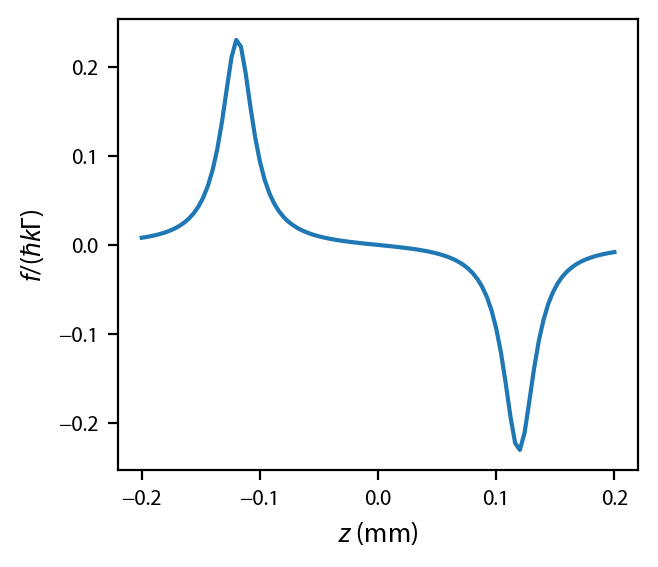

In [4]:
z = np.linspace(-0.2, 0.2, 101)/(10*x0)

R = np.array([np.zeros(z.shape), np.zeros(z.shape), z])
V = np.zeros((3,) + z.shape)

eqn.generate_force_profile(R, V, name='Fz')

fig, ax = plt.subplots(1, 1)

ax.plot(z*(10*x0), eqn.profile['Fz'].F[2])
ax.set_xlabel('$z$ (mm)')
ax.set_ylabel('$f/(\hbar k \Gamma)$');

Note in the paper they have the $F$ in units of N.  When adding the $\hbar k \Gamma$ to mine, I find my force is a factor of 2 lower than theirs in the plot.

### Dynamics

Before we run hundreds of simultions, let's first run a single simulation of an atom just to make sure that everything is working:

In [5]:
tmax = 0.05/t0
if isinstance(eqn, pylcp.rateeq):
    eqn.set_initial_pop(np.array([1., 0., 0., 0.]))
eqn.set_initial_position(np.array([0., 0., 0.]))
eqn.evolve_motion([0, tmax], random_recoil=True, progress_bar=True, max_step=1.)

Completed in 11.34 s.                                              


     message: The solver successfully reached the end of the integration interval.
     success: True
      status: 0
           t: [ 0.000e+00  2.322e-02 ...  2.356e+03  2.356e+03]
         sol: None
    t_events: None
    y_events: None
    t_random: [ 1.340e+02  1.370e+02 ...  2.322e+03  2.335e+03]
    n_random: [[1]
               [1]
               ...
               [1]
               [1]]
 inds_random: [False False ... False False]
        nfev: 18746
        njev: 0
         nlu: 0
           N: [[ 1.000e+00  9.994e-01 ...  9.159e-01  9.160e-01]
               [ 0.000e+00  2.016e-04 ...  7.311e-02  7.305e-02]
               [ 0.000e+00  2.016e-04 ...  8.077e-03  8.077e-03]
               [ 0.000e+00  2.016e-04 ...  2.884e-03  2.885e-03]]
           v: [[ 0.000e+00  0.000e+00 ... -1.908e-01 -1.888e-01]
               [ 0.000e+00  0.000e+00 ...  2.424e+00  2.421e+00]
               [ 0.000e+00 -9.344e-04 ...  6.770e-01  6.759e-01]]
           r: [[ 0.000e+00  0.000e+00 ... -2.848

Plot up this test solution:

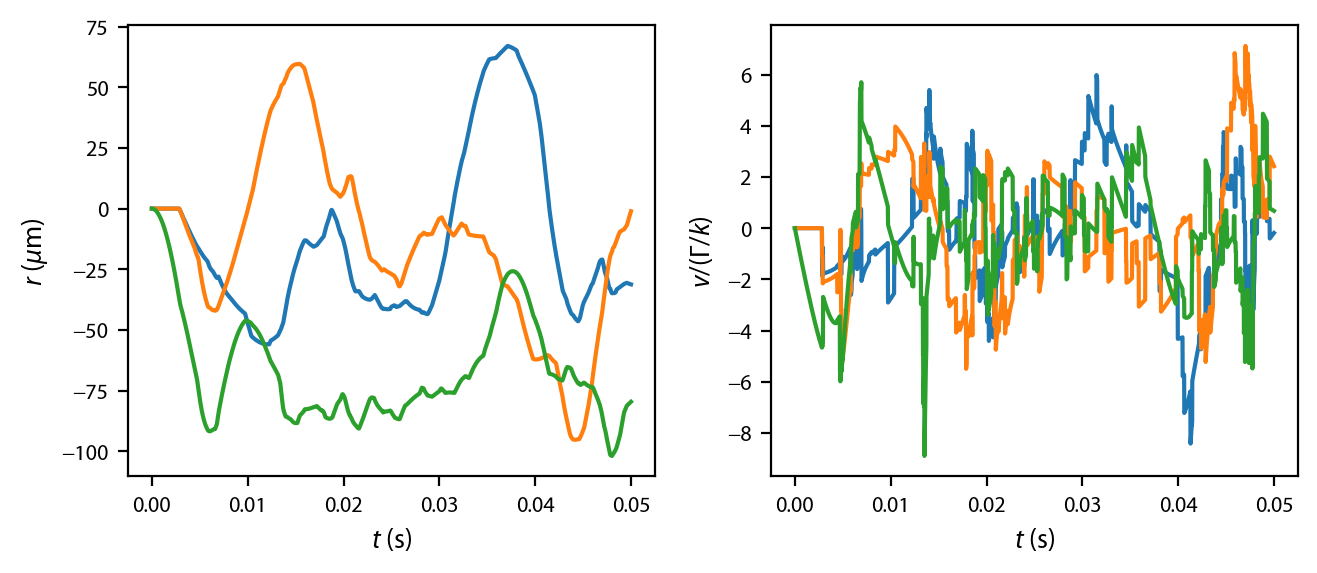

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(6.5, 2.75))
ax[0].plot(eqn.sol.t*t0, eqn.sol.r.T*(1e4*x0))
ax[1].plot(eqn.sol.t*t0, eqn.sol.v.T)
ax[0].set_ylabel('$r$ ($\mu$m)')
ax[0].set_xlabel('$t$ (s)')
ax[1].set_ylabel('$v/(\Gamma/k)$')
ax[1].set_xlabel('$t$ (s)')
fig.subplots_adjust(left=0.08, wspace=0.22)

### Now simulate _many_ atoms

Here, we use the `pathos` package to do parallel processing

In [7]:
import pathos
import copy

def generate_random_solution(mapargs):
    """
    A function for each subprocess to execute.  
    
    Parameters
    ----------
        mapargs : tuple
            tuple of (eqn, args, kwargs) of the index
            of the simulation, the eqn object to call evolve_motion,
            args and kwargs passed to evolve_motion.  Note that
            `rng` must be defined in kwargs 
            
    
    Notes
    -----
    All variables inside this function are defined locally, no
    global variables can be used as these are not overwritten 
    once the function is defined and dill pickled by pathos.
    This gets around the persistency problem of the ProcessPool.
    """
    # Unpack the unique arguments for this function call:
    eqn, args, kwargs = mapargs
    
    # Evolve motion:
    eqn.evolve_motion(*args, **kwargs)
    
    return eqn.sol

# Start the parallel process now, after defining generate_random_solution:
pool = pathos.pools.ProcessPool(nodes=4)

# Specify the number of atoms that we are simulated here:
Natoms = 1024

# Make a random number generator and use that to seed the random
# number generators for all the subprocesses through spawn.  These
# child rngs will then be passed to evolve_motion through the `rng`
# keyword argument.
rng = np.random.default_rng()
child_rngs = rng.spawn(Natoms)

# Define the common arguments and keyword arguments that will be 
# passed to the equations:
args = ([0, tmax], )
kwargs = {'t_eval':np.linspace(0, tmax, 1001),
          'random_recoil':True,
          'progress_bar':False,
          'max_scatter_probability':0.5,}

# Make a list of arguments for the generate_random_solution function 
# that we will map onto the parallel pool.  We copy the eqn object 
# so that each process executes on a different memory subspace, 
# otherwise we will have fun problems.
mapargs = []
for jj in range(Natoms):
    mapargs.append((copy.copy(eqn), args, {**kwargs, 'rng':child_rngs[jj]}))
    
# Map this list of tuples onto the parallel pool, in chunks so we 
# can monitor progress.
chunksize = 4
sols = []
progress = progressBar()
for jj in range(int(Natoms/chunksize)):
    sols += pool.map(generate_random_solution, mapargs[jj*chunksize:(jj+1)*chunksize])
    progress.update((jj+1)/int(Natoms/chunksize))

Completed in 34:32.                                                 


Plot up all the trajectories.  We make a basic ejected criterion, which says that if the atom flies more than 500 $\mu$m away from the origin in either $\hat{x}$ or $\hat{y}$, we say that atom is ejected:

Number of ejected atoms: 39


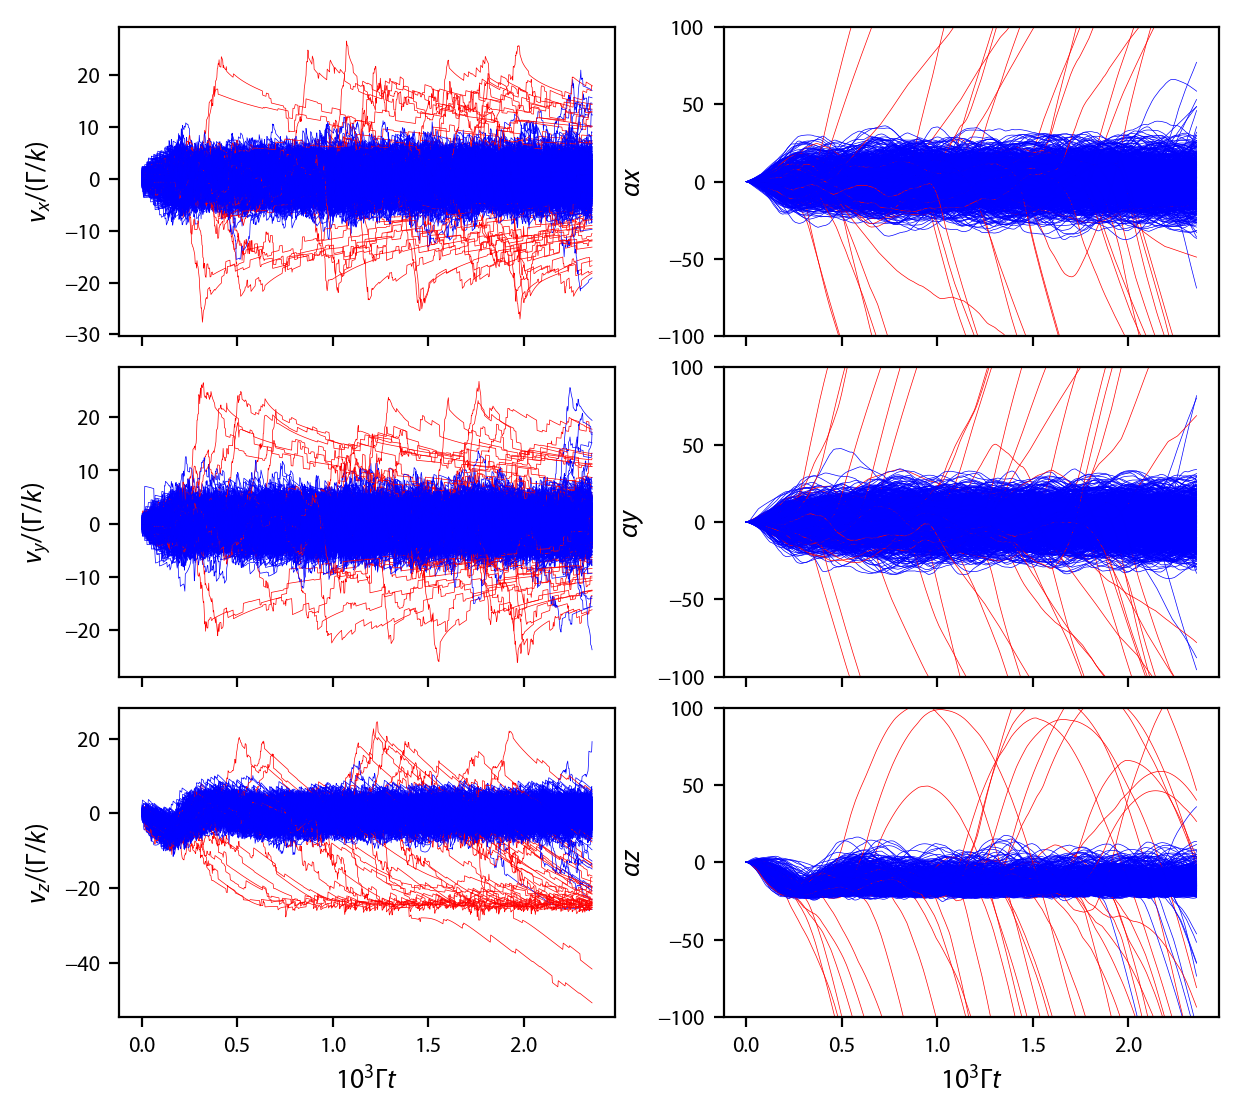

In [8]:
ejected = [np.bitwise_or(
    np.abs(sol.r[0, -1]*(1e4*x0))>500,
    np.abs(sol.r[1, -1]*(1e4*x0))>500
) for sol in sols]        

print('Number of ejected atoms: %d' % np.sum(ejected))
fig, ax = plt.subplots(3, 2, figsize=(6.25, 2*2.75))
for sol, ejected_i in zip(sols, ejected):
    for ii in range(3):
        if ejected_i:
            ax[ii, 0].plot(sol.t/1e3, sol.v[ii], color='r', linewidth=0.25)
            ax[ii, 1].plot(sol.t/1e3, sol.r[ii]*alpha, color='r', linewidth=0.25)
        else:
            ax[ii, 0].plot(sol.t/1e3, sol.v[ii], color='b', linewidth=0.25)
            ax[ii, 1].plot(sol.t/1e3, sol.r[ii]*alpha, color='b', linewidth=0.25)                

"""for ax_i in ax[:, 0]:
    ax_i.set_ylim((-0.75, 0.75))
for ax_i in ax[:, 1]:
    ax_i.set_ylim((-4., 4.))"""
for ax_i in ax[-1, :]:
    ax_i.set_xlabel('$10^3 \Gamma t$')
for jj in range(2):
    for ax_i in ax[jj, :]:
        ax_i.set_xticklabels('')
for ax_i, lbl in zip(ax[:, 0], ['x','y','z']):
    ax_i.set_ylabel('$v_' + lbl + '/(\Gamma/k)$')
for ax_i, lbl in zip(ax[:, 1], ['x','y','z']):
    ax_i.set_ylim((-100, 100))
    ax_i.set_ylabel('$\\alpha ' + lbl + '$')
    
fig.subplots_adjust(left=0.1, bottom=0.08, wspace=0.22)

Now, every 0.1 ms, bin the $x$ and $z$ coordinates, make a histogram, and simulate an image:

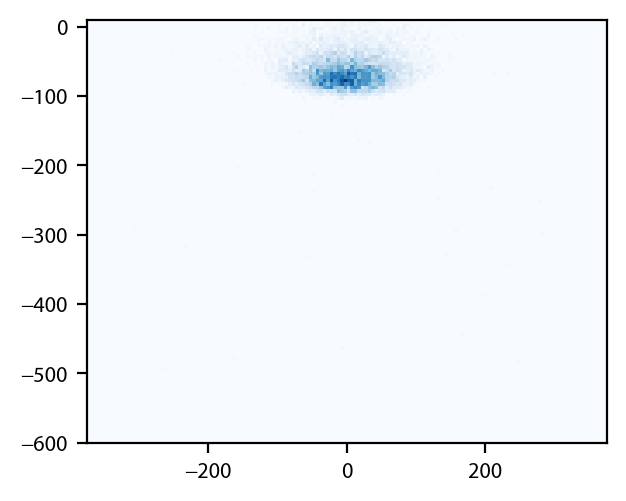

In [9]:
allx = np.array([], dtype='float64')
allz = np.array([], dtype='float64')

for sol in sols:
    allx = np.append(allx, sol.r[0][200::100]*(1e4*x0))
    allz = np.append(allz, sol.r[2][200::100]*(1e4*x0))
    
img, x_edges, z_edges = np.histogram2d(allx, allz, bins=[np.arange(-375, 376, 5.), np.arange(-600., 11., 5.)])

fig, ax = plt.subplots(1, 1)
im = ax.imshow(img.T, origin='lower',
               extent=(np.amin(x_edges), np.amax(x_edges),
                       np.amin(z_edges), np.amax(z_edges)),
               cmap='Blues',
               aspect='equal')

### Now, let's run the detuning

And produce the resulting simulated MOT images

In [10]:
dets = np.array([det, -400/7.5, -600/7.5, -800/7.5])
#s = 9

imgs = np.zeros(dets.shape + img.shape)
num_of_ejections = np.zeros(dets.shape)
num_of_ejections[0] = np.sum(ejected)
imgs[0] = img

for ii, det in enumerate(dets[1:]):
    # Rewrite the laser beams with the new detuning
    laserBeams = pylcp.conventional3DMOTBeams(delta=det, s=s,
                                              beam_type=pylcp.infinitePlaneWaveBeam)
    
    # Make the equation:
    eqn = pylcp.rateeq(laserBeams, magField, hamiltonian, g)
    if isinstance(eqn, pylcp.rateeq):
        eqn.set_initial_pop(np.array([1., 0., 0., 0.]))
        
    # Use the last equilibrium position to set this position:
    eqn.set_initial_position(np.array([0., 0., np.mean(allz)]))

    # Define the common arguments and keyword arguments that will be 
    # passed to the equations:
    args = ([0, tmax], )
    kwargs = {
        't_eval':np.linspace(0, tmax, 1001),
        'random_recoil':True,
        'progress_bar':False,
        'max_scatter_probability':0.5
    }

    # Make a list of arguments for the generate_random_solution function 
    # that we will map onto the parallel pool.  We copy the eqn object 
    # so that each process executes on a different memory subspace, 
    # otherwise we will have fun problems.
    mapargs = []
    for jj in range(Natoms):
        mapargs.append((copy.copy(eqn), args, {**kwargs, 'rng':child_rngs[jj]}))
    
    # Map this list of tuples onto the parallel pool, in chunks so we 
    # can monitor progress.
    chunksize = 4
    sols = []
    progress = progressBar()
    for jj in range(int(Natoms/chunksize)):
        sols += pool.map(generate_random_solution, mapargs[jj*chunksize:(jj+1)*chunksize])
        progress.update((jj+1)/int(Natoms/chunksize))
    
    # Generate the image:
    allx = np.array([], dtype='float64')
    allz = np.array([], dtype='float64')

    for sol in sols:
        allx = np.append(allx, sol.r[0][200::100]*(1e4*x0))
        allz = np.append(allz, sol.r[2][200::100]*(1e4*x0))

    img, x_edges, z_edges = np.histogram2d(allx, allz, bins=[x_edges, z_edges])
    
    # Save the image:
    imgs[ii+1] = img
    
    # Count the number of ejections:
    num_of_ejections[ii+1] = np.sum([np.bitwise_or(
        np.abs(sol.r[0, -1]*(1e4*x0))>500,
        np.abs(sol.r[1, -1]*(1e4*x0))>500
    ) for sol in sols])

Completed in 30:19.                                                 
Completed in 30:08.                                                 
Completed in 31:40.                                                 


Print out the statistics of the ejections:

In [11]:
print('Number of ejections: ', num_of_ejections)
print('Estimated lifetime: ', (-np.log((Natoms-num_of_ejections)/Natoms)/(tmax*t0)))

Number of ejections:  [39. 33. 39. 41.]
Estimated lifetime:  [0.77660329 0.65514543 0.77660329 0.81725371]


Now plot it up, with the ellipse indicating when the Zeeman shift from the magnetic field gradient equals the detuning 

Text(0, 0.5, '$z$ ($\\mu$m)')

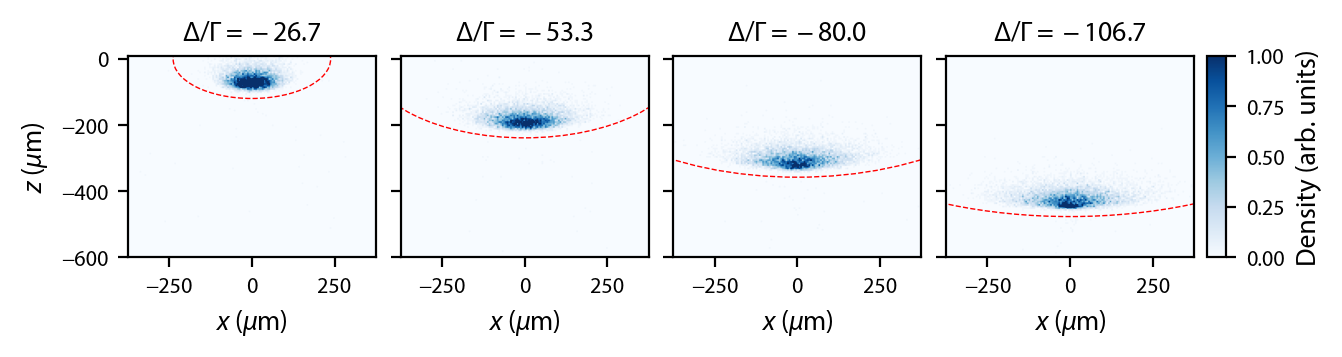

In [12]:
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(1, 4, figsize=(6.5, 1.625))

clims = [43, 35, 30, 25]
for ii in range(4):
    # Want to adjust scale for the increasing size of the MOT.  I thought this was clever:
    counts, bins = np.histogram(imgs[ii].flatten(), bins=np.arange(10, 500, 1))

    im = ax[ii].imshow(imgs[ii].T/(2.5*bins[np.argmax(counts)]), origin='lower',
                       extent=(np.amin(x_edges), np.amax(x_edges),
                               np.amin(z_edges), np.amax(z_edges)),
                       cmap='Blues', clim=(0, 1))
    ax[ii].set_title('$\Delta/\Gamma = %.1f$'%dets[ii])
    ax[ii].set_xlabel('$x$ ($\mu$m)')
    
    ellip = Ellipse(xy=(0,0),
                    width=4*dets[ii]/alpha*(1e4*x0),
                    height=2*dets[ii]/alpha*(1e4*x0),
                    linestyle='--',
                    linewidth=0.5,
                    facecolor='none',
                    edgecolor='red')
       
    ax[ii].add_patch(ellip)
    if ii>0:
        ax[ii].yaxis.set_ticklabels('')

fig.subplots_adjust(left=0.08, bottom=0.12, top=0.97, right=0.9)

pos = ax[-1].get_position()
cbar_ax = fig.add_axes([0.91, pos.y0, 0.015, pos.y1-pos.y0])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel('Density (arb. units)')

ax[0].set_ylabel('$z$ ($\mu$m)')